In [1]:
import os, time
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
device = "cuda"

In [2]:
trans_dig = transforms.Compose([
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1    
#         transforms.Normalize(mean=[0.08889289],std=[0.24106446])  #train_large dataset distribution
#         transforms.Normalize(mean=[0.08229437],std=[0.23876116]) #train dataset dist
#         transforms.Normalize(mean=[0.09549136],std=[0.24336776]) #dig_augmented distribution
    ])

trans = transforms.Compose([
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1    
#         transforms.Normalize(mean=[0.08889289],std=[0.24106446])  #train_large dataset distribution
#         transforms.Normalize(mean=[0.08229437],std=[0.23876116]) #train dataset dist
#         transforms.Normalize(mean=[0.09549136],std=[0.24336776]) #dig_augmented distribution
    ])


In [6]:
# train distribution: mean=[0.08229437],std=[0.23876116]
# dig augmented distribution: mean=[0.09549136],std=[0.24336776]
# train large distribution: mean=[0.08889286],std=[0.24106438]

def get_dataset_mean_std(dataloader):
    print("Calculate distribution:")
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in dataloader:
        img = data[0].to(device)
        batch_samples = img.size(0)
        img = img.contiguous().view(batch_samples, img.size(1), -1)
        mean += img.mean(2).sum(0)
        std += img.std(2).sum(0)
        nb_samples += batch_samples
        if nb_samples%5120 == 0:
            print("Finished:", nb_samples)
            
    print("num of samples:",nb_samples)
    mean /= nb_samples
    std /= nb_samples
#     print("Average mean:",mean)
#     print("Average std:", std)
    return mean.cpu().numpy(), std.cpu().numpy()


In [19]:
global_data = pd.read_csv("./dataset/train.csv")
global_aug_dig = pd.read_csv("./dataset/Dig-Mnist-Augmented.csv")
global_dig = pd.read_csv("./dataset/Dig-MNIST.csv")

class KMnistDataset(Dataset):
    def __init__(self,data_len=None, is_validate=False,validate_rate=None):
        self.is_validate = is_validate
        self.data = global_aug_dig
#         self.data = global_data
        print("data shape:", np.shape(self.data))
        if data_len == None:
            data_len = len(self.data)
        
        if self.is_validate:
            self.len = int(data_len*validate_rate)
            self.offset = int(data_len*(1-validate_rate))
            self.transform = trans_dig
        else:
            self.len = int(data_len*(1-validate_rate))
            self.offset = 0
            self.transform = trans
        
    def __getitem__(self, idx):
        idx += self.offset
        img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
        label = self.data.iloc[idx, 0]  #(num,)
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,28,28)
        label = torch.as_tensor(label, dtype=torch.uint8)    #value: 0~9, shape(1)
        return img, label

    def __len__(self):
        return self.len

In [ ]:
batch_size = 1024
num_workers = 4
vr = 0
k = 5
# indices_len = 60000
indices_len = 10240
# indices_len = 120000

###Single dataset
indices = np.arange(indices_len)
train_dataset = KMnistDataset(data_len=None,is_validate=False,validate_rate=vr,indices=indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
mean, std = get_dataset_mean_std(train_loader)
print("train distribution: mean={},std={}".format(mean, std))


# Visualize image

In [ ]:
for idx in range(2000,2010):
    i = np.random.randint(0,60000)
    fig, axes = plt.subplots(1,4,figsize=(8,2))
    img = global_data.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img = Image.fromarray(img)
    label = global_data.iloc[i, 0]
    axes[0].imshow(img,cmap="gray")
    img = trans(img).cpu().numpy().reshape(28,28)
    axes[1].imshow(img,cmap="gray")
    
    img = global_data_dig.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img = Image.fromarray(img)
    label = global_data_dig.iloc[i, 0]
    axes[2].imshow(img,cmap="gray")
    img = trans(img).cpu().numpy().reshape(28,28)
    axes[3].imshow(img,cmap="gray")
    
    plt.pause(.1)
    print("Label:",label)

# data.head(5)


# Test Imgaug Speed

In [ ]:
time_counter = np.zeros((5,))
for i in range(0,1000):
    img = global_data.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img = Image.fromarray(img)
    label = data.iloc[i, 0]
    img = np.array(img)
    t = time.clock()
    iaa.GaussianBlur(sigma=(0, 0.6)).augment_image(img)
    time_counter[0] += time.clock()-t
    
    t = time.clock()
    iaa.AverageBlur(2).augment_image(img)
    time_counter[1] += time.clock()-t
    
    
    t = time.clock()
    iaa.MedianBlur(3).augment_image(img)
    time_counter[2] += time.clock()-t
    
    t = time.clock()
    iaa.MotionBlur(180,-1).augment_image(img)
    time_counter[3] += time.clock()-t    

print(time_counter/1000)


# Diff between train_set and Dig_val set

In [5]:
import torch.nn as nn
import torch.nn.functional as F
class convNet(nn.Module):
    def __init__(self,in_channels):
        super(convNet,self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
        #                dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=64,kernel_size=3,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=64,eps=1e-3,momentum=0.01)
        self.c2 = nn.Conv2d(64,64,3,1,0)
        self.bn2 = nn.BatchNorm2d(64,1e-3,0.01)
        self.c3 = nn.Conv2d(64,64,5,1,2)
        self.bn3 = nn.BatchNorm2d(64,1e-3,0.01)
        self.m1 = nn.MaxPool2d(2)
        self.d1 = nn.Dropout(0.2)
        
        self.c4 = nn.Conv2d(64,128,3,1,0)
        self.bn4 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c5 = nn.Conv2d(128,128,3,1,0)
        self.bn5 = nn.BatchNorm2d(128,1e-3,0.01)
        self.c6 = nn.Conv2d(128,128,5,1,2)
        self.bn6 = nn.BatchNorm2d(128,1e-3,0.01)        
        self.m2 = nn.MaxPool2d(2)
        self.d2 = nn.Dropout(0.2)
        
        self.c7 = nn.Conv2d(128,256,3,1,0)
        self.bn7 = nn.BatchNorm2d(256,1e-3,0.01)
        self.m3 = nn.MaxPool2d(2)
        self.d3 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(256*1*1,256)
        self.bn8 = nn.BatchNorm1d(256,1e-3,0.01)
        
        self.fc2 = nn.Linear(256,128)
        self.bn9 = nn.BatchNorm1d(128,1e-3,0.01)
        
        self.out = nn.Linear(128,10)
        
        self.init_linear_weights()
        
    def forward(self,x):
        x = self.bn1(F.relu(self.c1(x)))
        x = self.bn2(F.relu(self.c2(x)))
        x = self.bn3(F.relu(self.c3(x)))
        x = self.m1(x)
        x = self.d1(x)
        
        x = self.bn4(F.relu(self.c4(x)))
        x = self.bn5(F.relu(self.c5(x)))
        x = self.bn6(F.relu(self.c6(x)))
        x = self.m2(x)
        x = self.d2(x)
        
        x = self.bn7(F.relu(self.c7(x)))
        x = self.m3(x)
        x = self.d3(x)        
        
        x = x.view(-1, 256*1*1) #reshape
        
        x = self.bn8(self.fc1(x))
        x = self.bn9(self.fc2(x))
        
        return self.out(x)
    
    def init_linear_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')  #default mode: fan_in
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in')
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in')

class convNet_native(nn.Module):
    def __init__(self,in_channels):
        super(convNet_native,self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=64,kernel_size=5,stride=1,padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=64,momentum=0.1)
        self.c2 = nn.Conv2d(64,64,5,1,2)
        self.bn2 = nn.BatchNorm2d(num_features=64,momentum=0.1)
        self.m1 = nn.MaxPool2d(2)
        self.d1 = nn.Dropout(0.2)
        
        self.c3 = nn.Conv2d(64,128,5,1,2)
        self.bn3 = nn.BatchNorm2d(128,0.1)
        self.c4 = nn.Conv2d(128,128,5,1,2)
        self.bn4 = nn.BatchNorm2d(128,0.1)
        self.m2 = nn.MaxPool2d(2)
        self.d2 = nn.Dropout(0.2)
        
        self.c5 = nn.Conv2d(128,256,3,1,1)
        self.bn5 = nn.BatchNorm2d(256,0.1)
        self.c6 = nn.Conv2d(256,256,3,1,1)
        self.bn6 = nn.BatchNorm2d(256,0.1)
        self.m3 = nn.MaxPool2d(2)
        self.d3 = nn.Dropout(0.2)

        self.fc = nn.Linear(256*3*3,256)  #layer for binary entropy
        self.d4 = nn.Dropout(0.2)
        self.out = nn.Linear(256,2)
        
    def forward(self,x):
        x = F.leaky_relu(self.bn1(self.c1(x)),negative_slope=0.1)
        x = F.leaky_relu(self.bn2(self.c2(x)),0.1)
        x = self.m1(x)
        x = self.d1(x)
        
        x = F.leaky_relu(self.bn3(self.c3(x)),0.1)
        x = F.leaky_relu(self.bn4(self.c4(x)),0.1)
        x = self.m2(x)
        x = self.d2(x)
        
        x = F.leaky_relu(self.bn5(self.c5(x)),0.1)
        x = F.leaky_relu(self.bn6(self.c6(x)),0.1)
        x = self.m3(x)
        x = self.d3(x)
        
        x = x.view(-1, 256*3*3) #reshape
        x_b = F.leaky_relu(self.fc(x),0.1)
        x_b = self.d4(x_b)
        return self.out(x_b)
    

In [ ]:
# native_model = convNet_native(in_channels=1)
# native_model.cuda()
# native_model.load_state_dict(torch.load("Kmnist_saved_model/native_classifier/Fold0_loss0.0242_acc_b99.704_without_aug"))
# native_model.eval()

# dig_model = convNet(in_channels=1)
# dig_model.cuda()
# dig_model.load_state_dict(torch.load("Kmnist_saved_model/Fold0_loss0.010_acc99.863"))
# dig_model.eval()

model = convNet(in_channels=1)
model.cuda()
model.load_state_dict(torch.load("Kmnist_saved_model/ensemble/10_fold_tuned_cnn/adam/Fold8_loss0.0033_acc99.917"))
model.eval()

In [21]:
vr = 1
dataset = KMnistDataset(data_len=None,is_validate=True, validate_rate=vr)
loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=4)

### Test Native Classifier
# counter = 0
# data_num = 0
# with torch.no_grad():
#     for idx,data in enumerate(loader):
#         img, label = data
#         img, label = img.to(device), label.to(device)
#         _,pred_native = torch.max(native_model(img),dim=1)
#         counter += (pred_native.cpu().numpy()).sum()
#         data_num += img.size(0)
        
# print("Native rate:",counter/data_num)
# print("Non Native rate:",1-(counter/data_num))

### Inference models
result = np.array([])
result_dig = np.array([])
labels = np.array([])
data_num = 0
with torch.no_grad():
    for idx,data in enumerate(loader):
        img, label = data
        img, label = img.to(device), label.to(device)
        _,pred = torch.max(model(img),dim=1)
#         _,pred_dig = torch.max(dig_model(img),dim=1)
        result = np.concatenate([result,pred.cpu().numpy()],axis=0)
#         result_dig = np.concatenate([result_dig,pred_dig.cpu().numpy()],axis=0)
        labels = np.concatenate([labels,label.cpu().numpy()],axis=0)
        data_num += img.size(0)

print("finished:",data_num)
print(np.shape(result),np.shape(result_dig),np.shape(labels))
  

data shape: (60000, 785)
finished: 60000
(60000,) (0,) (60000,)


              precision    recall  f1-score   support

         0.0       0.84      0.59      0.69      6000
         1.0       0.89      0.62      0.73      6000
         2.0       0.69      0.71      0.70      6000
         3.0       0.80      0.50      0.61      6000
         4.0       0.82      0.64      0.72      6000
         5.0       0.33      0.95      0.49      6000
         6.0       0.65      0.58      0.61      6000
         7.0       0.76      0.54      0.63      6000
         8.0       0.79      0.67      0.73      6000
         9.0       0.80      0.66      0.72      6000

    accuracy                           0.65     60000
   macro avg       0.74      0.65      0.66     60000
weighted avg       0.74      0.65      0.66     60000



Text(0.5, 69.0, 'Predicted label')

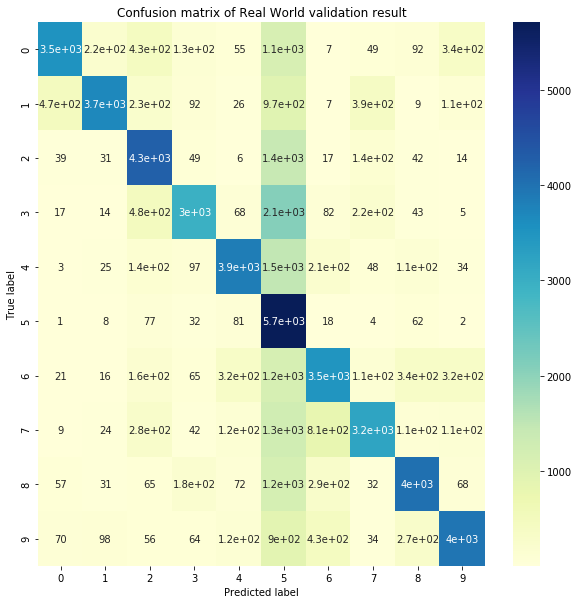

In [22]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

###Confusion matrix
print(classification_report(labels, result))
plt.figure(figsize=(10,10))
confusion_mat = confusion_matrix(labels, result)
sn.heatmap(confusion_mat, annot=True, cmap='YlGnBu')
plt.title('Confusion matrix of Real World validation result')
plt.ylabel('True label')
plt.xlabel('Predicted label')


933 15 922
922
141


Text(0, 0.5, 'frequency')

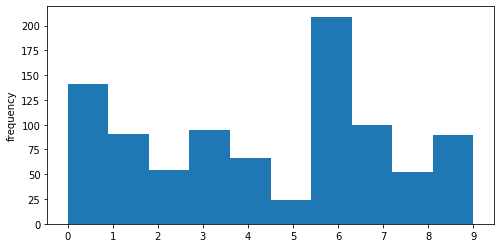

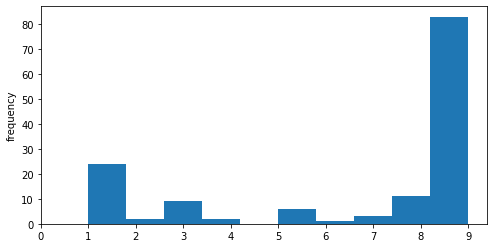

In [104]:
indices1 = np.where(result!=labels)[0]       #(num)
indices2 = np.where(result_dig!=labels)[0]
indices3 = np.where((result!=labels)&(result_dig==labels))[0]

cirtic_label_list = []
label_list = []

print(len(indices1),len(indices2),len(indices3))  #dig: 912 51 878
#up: 954
for i in range(len(indices3)):
    idx = indices3[i]
    img1 = global_data_dig.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img1 = Image.fromarray(img1)
    label1 = result[idx]
    label2 = result_dig[idx]
    label = labels[idx]
    cirtic_label_list.append(label)
    
    if label ==0:
        label_list.append(label1)
    else:
        continue
    
#     fig, axes = plt.subplots(1,1,figsize=(1,1))
#     axes.imshow(img1,cmap="gray")
#     plt.pause(.1)
#     print("Model:",label1," Model2:",label2," Label:",label)

plt.figure(figsize=(8,4))
data = np.uint8(cirtic_label_list)
print(len(data))
plt.hist(data ,density=0,align="mid",bins=10,rwidth=1)
plt.xticks(range(10))
plt.ylabel('frequency')

plt.figure(figsize=(8,4))
data = np.uint8(label_list)
print(len(data))
plt.hist(data ,density=0,align="mid",bins=10,rwidth=1)
plt.xticks(range(10))
plt.ylabel('frequency')

# Combine train.csv and Dig augmented, add additional "native writer label"

In [154]:
pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "native_label,label," + pix_str

origin_data = pd.read_csv("./dataset/train.csv")
dig_aug_data = pd.read_csv("./dataset/Dig-Mnist-Augmented.csv")

In [155]:
train_csv = np.array(origin_data).astype(int)
dig_aug_csv = np.array(dig_aug_data).astype(int)
native_label0 = np.zeros((60000,1)).astype(int)
native_label1 = np.ones((60000,1)).astype(int)

train_csv = np.concatenate([native_label1,train_csv],axis=1)
dig_aug_csv = np.concatenate([native_label0,dig_aug_csv],axis=1)

print(np.shape(train_csv))
print(np.shape(dig_aug_csv))
new_csv = np.vstack([train_csv,dig_aug_csv])
print(np.shape(new_csv))
np.savetxt("./dataset/large_train.csv", new_csv, delimiter=",",fmt="%d",header=numpy_header,comments='')



(60000, 786)
(60000, 786)
(120000, 786)


# Augment dig dataset

In [ ]:
vr = 0
batch_size = 1024
dataset = KMnistDataset(data_len=None,is_validate=False, validate_rate=vr)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
num_per_class = 6000  # 6000 * 10 =60000

pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "label," + pix_str

dig_data = pd.read_csv("./dataset/Dig-MNIST.csv")
# dig_data.head(5)


In [ ]:
aug_list = np.empty((0,785))
counter_list = np.zeros((10,)).astype(int)

###Load original 10240 data
origin_img = dig_data.iloc[:, 1:].values.astype(np.uint8).reshape((-1,784))  #value: 0~255
origin_label = np.array(dig_data.iloc[:,0]).astype(int)

for i in range(len(origin_img)):
    if i%1000==0:
        print(i)
    tmp_img = origin_img[i]    #(784,)
    tmp_label = origin_label[i].reshape(-1) #(1,)
    csv_arr = np.concatenate([tmp_label,tmp_img])   #(785,)
    aug_list = np.vstack((aug_list,csv_arr))
    counter_list[tmp_label] += 1

print("shape of aug_list:",np.shape(aug_list))
print("counter_list:",counter_list)

In [ ]:
###Augment data by random select and affine
keep_loop = True
while keep_loop:
    for idx,data in enumerate(loader):
        img, label = data
        img, label = img.to(device), label.to(device)

        img = img.cpu().numpy()
        img = np.uint8(img*255).reshape(batch_size,-1)
        label = label.cpu().numpy()
        
        for i in range(batch_size):
            tmp_img = img[i]    #(784,)
            tmp_label = label[i].reshape(-1) #(1,)
            if counter_list[tmp_label] >= num_per_class:
                continue
#             print(np.shape(tmp_label),np.shape(tmp_img))
            csv_arr = np.concatenate([tmp_label,tmp_img])   #(785,)
#             print("csv arr shape:",np.shape(csv_arr))
            
            aug_list = np.vstack((aug_list,csv_arr))
#             print("aug_list shape:",np.shape(aug_list))
            counter_list[tmp_label] += 1

        print("shape of aug_list:",np.shape(aug_list))
        print("counter_list:",counter_list)
        if (counter_list>=num_per_class).all() == True:
            print("Augment Finished")
            print(np.shape(aug_list))
            print(counter_list)
            np.savetxt("./dataset/Dig-Mnist-Augmented.csv", aug_list, delimiter=",",fmt="%d",header=numpy_header,comments='')
            keep_loop = False
            break

# Show data distribution

In [163]:
# data = np.random.random([1000,])
global_data = pd.read_csv("./dataset/train_large.csv")

(120000,)


([<matplotlib.axis.XTick at 0x7fcba9ac25c0>],
 <a list of 1 Text xticklabel objects>)

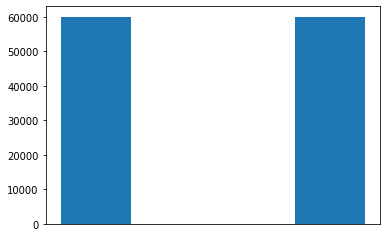

In [171]:
data = global_data.iloc[:,0]
print(np.shape(data))

plt.hist(data ,density=0,label=True,bins=2,rwidth=0.3)
plt.xticks(range(0,1))
# print((label==5).sum().item())
# plt.ylabel('frequency')

In [ ]:
plt.hist(data ,density=1,bins=10,label=True,rwidth=0.6)
plt.ylabel('frequency')